In [1]:
# CNN-VIT 视频分类

In [2]:
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

import IPython
from IPython.display import Image

2022-09-22 17:53:43.483016: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
# 序列长度（视频采样帧数）
MAX_SEQ_LENGTH = 20
# CNN提取特征向量大小
NUM_FEATURES = 1536
# 裁剪图片大小
IMG_SIZE = 299


In [4]:
# 读取文件名、标注
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")


In [5]:
train_df.sample(10)

video_name             tag
1918        v_Drumming_g15_c01.avi        Drumming
1736     v_CricketShot_g20_c06.avi     CricketShot
5203  v_WritingOnBoard_g11_c02.avi  WritingOnBoard
2999        v_JumpRope_g19_c03.avi        JumpRope
3268    v_PlayingCello_g12_c01.avi    PlayingCello
5188  v_WritingOnBoard_g08_c04.avi  WritingOnBoard
4336          v_Rowing_g21_c05.avi          Rowing
1484     v_CliffDiving_g14_c01.avi     CliffDiving
4677  v_SoccerJuggling_g09_c06.avi  SoccerJuggling
548       v_Basketball_g13_c04.avi      Basketball

In [6]:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub

# 裁剪正中间的正方形
def crop_center_square(img):
    # 获取长度和宽度
    h,w =  img.shape[:2]
    # 判断短边，作为正方形的边
    square_w = min(h,w)
    
    start_x = w//2 - square_w//2
    end_x = start_x + square_w
    
    start_y = h//2 - square_w//2
    end_y = start_y + square_w
    
    result = img[start_y:end_y,start_x:end_x]
    
    return result

# 加载视频
def load_video(filename):
    cap = cv2.VideoCapture(filename)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # 中心裁剪
        frame = crop_center_square(frame)
        # 缩放
        frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        # BGR->RGB
        frame = frame[:, :, [2, 1, 0]]
        frames.append(frame)

    return np.array(frames)


In [7]:
# 测试一个文件
test_file = train_df['video_name'].values[200]
test_file

'v_Archery_g25_c03.avi'

In [8]:
frames = load_video(os.path.join('train', test_file))

In [9]:
frames.shape

(203, 299, 299, 3)

In [10]:
# 挑选前20帧显示
frames = frames[:20].astype(np.uint8)
# 保存为GIF
imageio.mimsave("animation.gif", frames, fps=10)

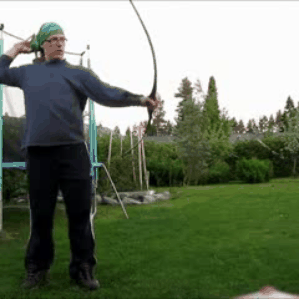

In [11]:
Image(filename='animation.gif',embed=True)

In [12]:

# 特征提取器
def build_feature_extractor():
    
    feature_extractor = keras.applications.inception_resnet_v2.InceptionResNetV2(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_resnet_v2.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()


2022-09-22 17:53:47.175722: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-09-22 17:53:47.213066: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:d1:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-09-22 17:53:47.213100: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-09-22 17:53:47.215922: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-09-22 17:53:47.215997: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-09-22 17:53:47.216828: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcu

In [13]:
feature_extractor.summary()

Model: "feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 299, 299, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 1536)              54336736  
Total params: 54,336,736
Trainable params: 54,276,192
Non-trainable params: 60,544
_________________________________________________________________


In [14]:
# 所有标注
class_vocab = pd.unique(train_df["tag"]).tolist()

In [15]:
class_vocab

['ApplyEyeMakeup',
 'Archery',
 'BabyCrawling',
 'BandMarching',
 'BaseballPitch',
 'Basketball',
 'BasketballDunk',
 'BenchPress',
 'Biking',
 'Billiards',
 'Bowling',
 'BoxingPunchingBag',
 'BoxingSpeedBag',
 'BrushingTeeth',
 'CliffDiving',
 'CricketBowling',
 'CricketShot',
 'Diving',
 'Drumming',
 'FrontCrawl',
 'GolfSwing',
 'Haircut',
 'Hammering',
 'HammerThrow',
 'HandstandPushups',
 'HeadMassage',
 'HorseRiding',
 'IceDancing',
 'JumpRope',
 'Kayaking',
 'Nunchucks',
 'PlayingCello',
 'PlayingDaf',
 'PlayingDhol',
 'PlayingFlute',
 'PlayingGuitar',
 'PlayingSitar',
 'PoleVault',
 'Punch',
 'RockClimbingIndoor',
 'Rowing',
 'ShavingBeard',
 'Shotput',
 'Skiing',
 'SoccerJuggling',
 'SoccerPenalty',
 'TableTennisShot',
 'TennisSwing',
 'WallPushups',
 'WritingOnBoard']

In [16]:
# train_df["tag"].values.tolist()

In [17]:
# 加载RNN处理好的数据
train_data, train_labels = np.load('./data_processed/train_data_incep.npy'),np.load('./data_processed/train_labels_incep.npy')
test_data, test_labels = np.load('./data_processed/test_data_incep.npy'),np.load('./data_processed/test_labels_incep.npy')

In [18]:
train_data.shape,train_labels.shape,test_data.shape,test_labels.shape

((5292, 20, 1536), (5292, 1), (2045, 20, 1536), (2045, 1))

In [19]:
# 位置编码positional embedding

![](https://enpei-md.oss-cn-hangzhou.aliyuncs.com/img20220922174659.png?x-oss-process=style/wp)

In [20]:
# 位置编码，流程如上图所示
class PositionalEmbedding(layers.Layer):
    def __init__(self,seq_length,output_dim):
        super().__init__()
        self.positional_embedding = layers.Embedding(input_dim=seq_length,output_dim=output_dim)
    
    def call(self,x):
        # 构造从0~MAX_SEQ_LENGTH的列表
        positions = tf.range(0,limit=MAX_SEQ_LENGTH)
        # 位置编码
        positions_embedding = self.positional_embedding(positions)
        # 与输入相加
        return x + positions_embedding

In [21]:
# encoder

![](https://enpei-md.oss-cn-hangzhou.aliyuncs.com/img20220922174719.png?x-oss-process=style/wp)

In [22]:
# 编码器
class TransformerEncoder(layers.Layer):
    
    def __init__(self,num_heads, embed_dim):
        super().__init__()
        
        self.p_embedding = PositionalEmbedding(MAX_SEQ_LENGTH, NUM_FEATURES)
        self.attention = layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim, dropout = 0.1)
        self.layernorm = layers.LayerNormalization()
    
    def call(self,x):
        # positional embedding
        positional_embedding = self.p_embedding(x)
        # self attention
        attention_out = self.attention(
            query = positional_embedding,
            value = positional_embedding,
            key = positional_embedding,
            attention_mask=None,
        )
        # layer norm with residual connection        
        output = self.layernorm(positional_embedding + attention_out)
        return output

In [23]:
# 定义模型
def video_cls_model(class_vocab):
    # 类别数量
    classes_num = len(class_vocab)

    model = keras.Sequential([
        layers.InputLayer(input_shape=(MAX_SEQ_LENGTH, NUM_FEATURES)),
        TransformerEncoder(1,NUM_FEATURES),
        layers.GlobalMaxPooling1D(),
        layers.Dropout(0.1),
        layers.Dense(classes_num, activation="softmax")
    ])
    # 编译模型
    model.compile(
        optimizer=optimizers.Adam(0.00005), loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [24]:
model = video_cls_model(class_vocab)

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer_encoder (Transfo (None, 20, 1536)          9477120   
_________________________________________________________________
global_max_pooling1d (Global (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                76850     
Total params: 9,553,970
Trainable params: 9,553,970
Non-trainable params: 0
_________________________________________________________________


In [26]:
# 训练
filepath = "./saved_model/vit/transformer_video_cls"
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_accuracy', save_weights_only=True, save_best_only=True, verbose=1
)
    
history = model.fit(
        train_data,
        train_labels,
        validation_data=(test_data, test_labels),
        epochs=30,
        callbacks=[checkpoint],
    )

2022-09-22 17:53:54.946132: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-22 17:53:54.947420: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2600000000 Hz


Epoch 1/30


2022-09-22 17:53:55.707750: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-09-22 17:53:56.499139: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-09-22 17:53:56.499206: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-09-22 17:53:56.500669: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8


 15/166 [=>............................] - ETA: 1s - loss: 4.4546 - accuracy: 0.0833

2022-09-22 17:53:57.148245: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101


166/166 [==============================] - 4s 10ms/step - loss: 1.5945 - accuracy: 0.5947 - val_loss: 0.8629 - val_accuracy: 0.7496

Epoch 00001: val_accuracy improved from -inf to 0.74963, saving model to ./saved_model/vit/transformer_video_cls
Epoch 2/30
166/166 [==============================] - 1s 8ms/step - loss: 0.4275 - accuracy: 0.8738 - val_loss: 0.7339 - val_accuracy: 0.8127

Epoch 00002: val_accuracy improved from 0.74963 to 0.81271, saving model to ./saved_model/vit/transformer_video_cls
Epoch 3/30
166/166 [==============================] - 1s 8ms/step - loss: 0.2420 - accuracy: 0.9308 - val_loss: 0.7092 - val_accuracy: 0.8122

Epoch 00003: val_accuracy did not improve from 0.81271
Epoch 4/30
166/166 [==============================] - 1s 8ms/step - loss: 0.1536 - accuracy: 0.9596 - val_loss: 0.6953 - val_accuracy: 0.8225

Epoch 00004: val_accuracy improved from 0.81271 to 0.82249, saving model to ./saved_model/vit/transformer_video_cls
Epoch 5/30
166/166 [==================

In [27]:
# 测试训练好的模型
model.load_weights(filepath)
loss, accuracy = model.evaluate(test_data, test_labels)

64/64 [==============================] - 0s 3ms/step - loss: 0.8264 - accuracy: 0.8548


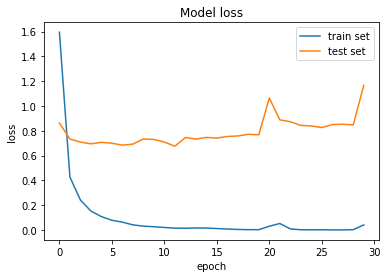

In [28]:
# 查看损失
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train set','test set'],loc='upper right')
plt.show()

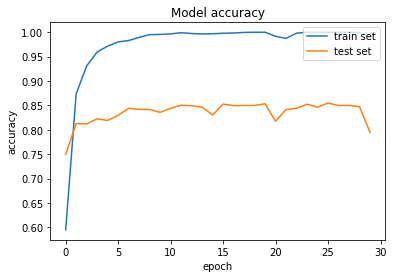

In [29]:
# 查看acc
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train set','test set'],loc='upper right')
plt.show()